<!-----
title: How To use FastAILRFinder with Ignite
downloads: true
sidebar: true
tags:
  - lr finder
  - fastai lr finder
--- 
-->

This how-to guide demonstrates how we can leverage the [`FastaiLRFinder`](https://pytorch.org/ignite/generated/ignite.handlers.lr_finder.FastaiLRFinder.html) handler to find an optimal learning rate to train our model on. We will compare the results produced with and without using the handler for better understanding.

<!--more-->

In this example, we will be using a [ResNet18](https://pytorch.org/vision/stable/models.html#torchvision.models.resnet18) model on the [MNIST](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.MNIST) dataset. The base code is the same as used in the [Getting Started Guide](https://pytorch-ignite.ai/getting-started).

## Basic Setup

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.models import resnet18
from torchvision.transforms import Compose, Normalize, ToTensor

from ignite.engine import create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.handlers import FastaiLRFinder

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.model = resnet18(num_classes=10)
        self.model.conv1 = nn.Conv2d(
            1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), bias=False
        )

    def forward(self, x):
        return self.model(x)


model = Net().to(device)

data_transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

train_loader = DataLoader(
    MNIST(download=True, root=".", transform=data_transform, train=True),
    batch_size=128,
    shuffle=True,
)

test_loader = DataLoader(
    MNIST(download=True, root=".", transform=data_transform, train=False),
    batch_size=256,
    shuffle=False,
)


model = Net().to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-06)
criterion = nn.CrossEntropyLoss()

We will first train the model with a fixed learning rate (lr) of 1e-06 and inspect our results. Let's save the initial state of the model and the optimizer to restore them later for comparision.

In [23]:
init_model_state = model.state_dict()
init_opt_state = optimizer.state_dict()

In [24]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

trainer.run(train_loader, max_epochs=3)

State:
	iteration: 1407
	epoch: 3
	epoch_length: 469
	max_epochs: 3
	output: 0.5554001927375793
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [25]:
evaluator = create_supervised_evaluator(
    model, metrics={"Accuracy": Accuracy(), "Loss": Loss(criterion)}, device=device
)
evaluator.run(test_loader)

print(evaluator.state.metrics)

{'Accuracy': 0.8655, 'Loss': 0.602867822265625}


Let's see how we can achieve better results by using the `FastAILRFinder` handler. But first, let's restore the initial state of the model and optimizer so we can re-train them from scratch. 

In [26]:
model.load_state_dict(init_model_state)
optimizer.load_state_dict(init_opt_state)

When attached to the `trainer`, this handler follows the same procedure used by [fastai](https://docs.fast.ai/callback.schedule.html#LRFinder). The model is trained for `num_iter` iterations while the learning rate is increased from `start_lr` (defaults to initial value specified by the optimizer, here 1e-06) to the upper bound called `end_lr`. This increase can be linear (`step_mode="linear"`) or exponential (`step_mode="exp"`). The default `step_mode` is exponential which is recommended for larger learning rate ranges while linear provides good results for small ranges.

In [27]:
lr_finder = FastaiLRFinder()

# To restore the model's and optimizer's states after running the LR Finder
to_save = {"model": model, "optimizer": optimizer}

with lr_finder.attach(trainer, to_save, end_lr=1e-02) as trainer_with_lr_finder:
    trainer_with_lr_finder.run(train_loader)

Let's plot how the learning rate changes within our specified range and print the suggested learning rate.

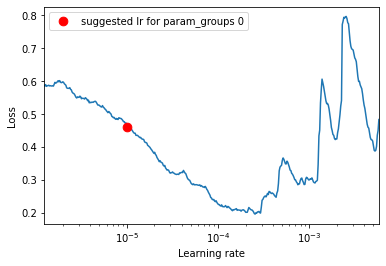

Suggested LR 1.0148376909312998e-05


In [28]:
lr_finder.plot()

print("Suggested LR", lr_finder.lr_suggestion())

Now we will apply the suggested learning rate to the optimizer, and train the model again with optimal learning rate.

In [29]:
lr_finder.apply_suggested_lr(optimizer)
print(optimizer.param_groups[0]["lr"])

1.0148376909312998e-05


In [30]:
trainer.run(train_loader, max_epochs=3)

State:
	iteration: 1407
	epoch: 3
	epoch_length: 469
	max_epochs: 3
	output: 0.09644963592290878
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [31]:
# Calculate the new metrics after using the optimal lr
evaluator.run(test_loader)
print(evaluator.state.metrics)

{'Accuracy': 0.9715, 'Loss': 0.0908882568359375}


As we saw the accuracy increased and loss decreased on the test dataset when we trained our model for the same number of epochs with an optimal learning rate.